In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
from pathlib import Path

sys.path.append("..")

In [3]:
import tensorflow as tf
import torch

from librep.transforms import TSNE
from librep.transforms import UMAP
from librep.datasets.multimodal import TransformMultiModalDataset, ArrayMultiModalDataset
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

2022-09-29 16:33:45.186483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 16:33:45.186563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
dataset = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(train_x, train_y), (test_x, test_y) = dataset

In [5]:
train_x_reordered = train_x.reshape((60000,-1))
print('TRAIN_X_REORDERED', train_x_reordered.shape)

test_x_reordered = test_x.reshape((10000,-1))
print('TEST_X_REORDERED', test_x_reordered.shape)


TRAIN_X_REORDERED (60000, 784)
TEST_X_REORDERED (10000, 784)


In [6]:
mnist_dataset_train = ArrayMultiModalDataset(X=train_x_reordered, y=train_y, window_slices=[(0, 28*28)], 
                                             window_names=["px"])
mnist_dataset_test = ArrayMultiModalDataset(X=test_x_reordered, y=test_y, window_slices=[(0, 28*28)], 
                                             window_names=["px"])

In [7]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder

In [8]:
# topo_transformer = TopologicallyRegularizedAutoencoder(autoencoder_model='DeepAE')
# optimizer = torch.optim.Adam(topo_transformer.parameters(), lr=1e-3, weight_decay=1e-5)
# autoencoder_model='DeepAE'
# data_loader = torch.utils.data.DataLoader(dataset=train_x, batch_size=128, shuffle=True)

Topologically Regularized DeepAE
Using python to compute signatures
Epoch:1, Loss:7562.2653, Loss-ae:7221.8420, Loss-topo:340.4232
Epoch:2, Loss:7292.1494, Loss-ae:7217.0180, Loss-topo:75.1314
Epoch:3, Loss:7288.6327, Loss-ae:7216.9708, Loss-topo:71.6619
Epoch:4, Loss:7286.6303, Loss-ae:7217.1716, Loss-topo:69.4587
Epoch:5, Loss:7285.8846, Loss-ae:7217.1114, Loss-topo:68.7731
Epoch:6, Loss:7289.9265, Loss-ae:7217.0673, Loss-topo:72.8592
Epoch:7, Loss:7285.6543, Loss-ae:7217.0795, Loss-topo:68.5748
Epoch:8, Loss:7284.9015, Loss-ae:7216.9887, Loss-topo:67.9129
Epoch:9, Loss:7285.6200, Loss-ae:7217.2038, Loss-topo:68.4163
Epoch:10, Loss:7285.8337, Loss-ae:7216.9293, Loss-topo:68.9045
Epoch:11, Loss:7287.8589, Loss-ae:7217.2234, Loss-topo:70.6355
Epoch:12, Loss:7285.8349, Loss-ae:7216.9219, Loss-topo:68.9130
Epoch:13, Loss:7286.0516, Loss-ae:7216.9719, Loss-topo:69.0797
Epoch:14, Loss:7285.7957, Loss-ae:7216.9188, Loss-topo:68.8769
Epoch:15, Loss:7287.6445, Loss-ae:7217.2764, Loss-topo:70.

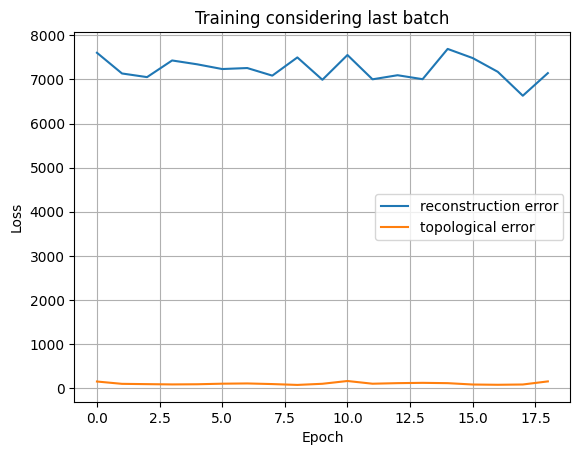

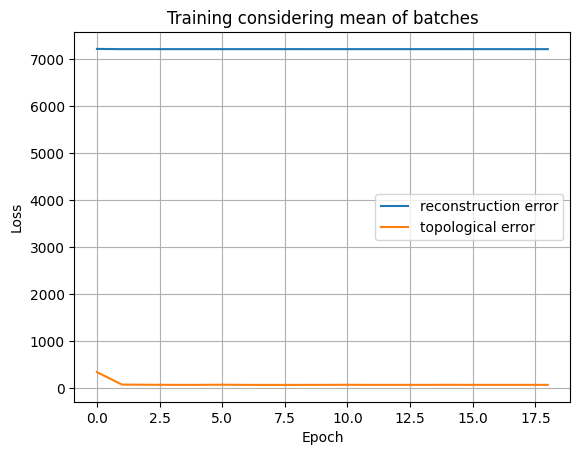

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


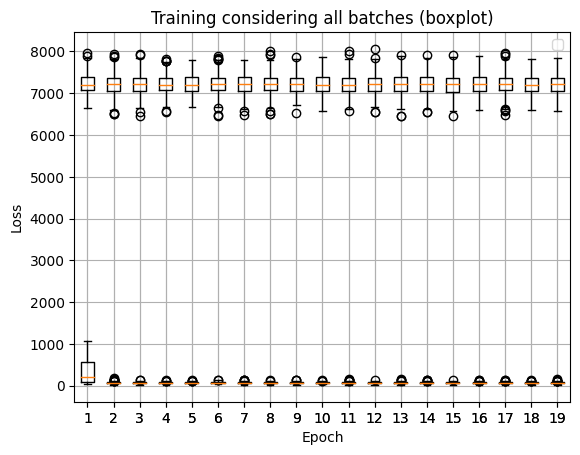

In [9]:
transform_topoae = TopologicalDimensionalityReduction(ae_model='DeepAE')
transform_topoae.fit(mnist_dataset_train.X)
# assert 1==0

In [10]:
test_applied_topoae = transform_topoae.transform(mnist_dataset_test.X)

In [11]:
print(test_applied_topoae.shape)

(10000, 2)


In [27]:
from librep.transforms import TSNE
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, Y):
    data_grouped = list(zip(X, Y))
    uniques = np.unique(Y)
    for uval in np.unique(Y):
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    plt.legend()
    plt.show()


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


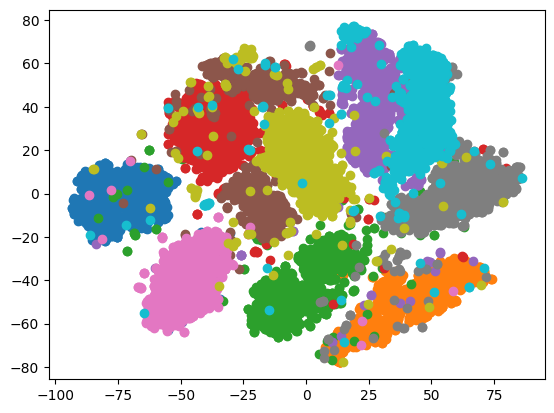

In [25]:
transformed = TSNE().fit_transform(mnist_dataset_test.X)

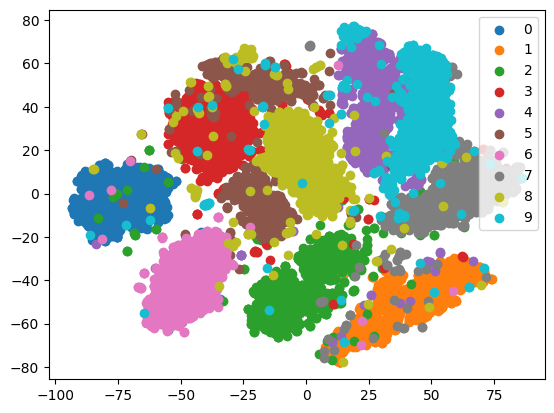

In [28]:
visualize(transformed, mnist_dataset_test.y)

In [12]:
metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=128)
metrics_train_applied_topoae = metrics_reporter.evaluate([mnist_dataset_test, test_applied_topoae])
print(metrics_train_applied_topoae)

{'residual variance (pearson)': 0.9088916784040973, 'residual variance (spearman)': 0.9357263957211669, 'trustworthiness': 0.7330770731361281, 'continuity': 0.7848511935618233, 'co k nearest neighbor size': 0.31437386432465175, 'local continuity meta criterion': 0.18738973734052475, 'local property': 0.24520766063677016, 'global property': 0.6605379259278532}


In [13]:
metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=500)
metrics_train_applied_topoae = metrics_reporter.evaluate([mnist_dataset_test, test_applied_topoae])
print(metrics_train_applied_topoae)

{'residual variance (pearson)': 0.9420338652827465, 'residual variance (spearman)': 0.9512962998773056, 'trustworthiness': 0.7125708845226686, 'continuity': 0.8214935175734492, 'co k nearest neighbor size': 0.16106588176352704, 'local continuity meta criterion': 0.12893736770730216, 'local property': 0.23542202010936072, 'global property': 0.6592536769332423}


In [14]:
metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=1000)
metrics_train_applied_topoae = metrics_reporter.evaluate([mnist_dataset_test, test_applied_topoae])
print(metrics_train_applied_topoae)

{'residual variance (pearson)': 0.9478856702660299, 'residual variance (spearman)': 0.951948136813727, 'trustworthiness': 0.7091829749383157, 'continuity': 0.8394804328743799, 'co k nearest neighbor size': 0.1108420920920921, 'local continuity meta criterion': 0.09481002796383557, 'local property': 0.22949850254064758, 'global property': 0.6577808658572575}
